# Final Project 
## Analysis of Subway usage of Seoul using based on signal processing 

### How things go:
+ Obtain temporal Seoul subway usage data
+ Extract features using fourier transformation (or wavelet transfomr)
+ Cluster based on similarity
+ Analyze the result based on urban context

### 1. Obtain temporal Seoul subway usage data
+ Data is retrieved from [http://data.seoul.go.kr/dataList/OA-12252/S/1/datasetView.do]

In [11]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
raw_path = './Rawdata/서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv'

raw_df = pd.read_csv(raw_path)
sample_df = raw_df[raw_df['사용월'] >= 202101]

In [3]:
start_times = [str(i).zfill(2)+'시-'+str(i+1).zfill(2)+'시 '  for i in range(4, 24)]
end_times = [str(i).zfill(2)+'시-'+str(i+1).zfill(2)+'시 '  for i in range(0, 4)]

times = start_times + end_times
in_times = [i + '승차인원' for i in times]
out_times = [i + '하차인원' for i in times]

col_names = ['사용월', '호선명','지하철역']
in_cols = col_names + in_times
out_cols = col_names + out_times
in_df = sample_df[in_cols]
out_df = sample_df[out_cols]

in_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2423 entries, 0 to 2422
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   사용월           2423 non-null   int64 
 1   호선명           2423 non-null   object
 2   지하철역          2423 non-null   object
 3   04시-05시 승차인원  2423 non-null   int64 
 4   05시-06시 승차인원  2423 non-null   int64 
 5   06시-07시 승차인원  2423 non-null   int64 
 6   07시-08시 승차인원  2423 non-null   int64 
 7   08시-09시 승차인원  2423 non-null   int64 
 8   09시-10시 승차인원  2423 non-null   int64 
 9   10시-11시 승차인원  2423 non-null   int64 
 10  11시-12시 승차인원  2423 non-null   int64 
 11  12시-13시 승차인원  2423 non-null   int64 
 12  13시-14시 승차인원  2423 non-null   int64 
 13  14시-15시 승차인원  2423 non-null   int64 
 14  15시-16시 승차인원  2423 non-null   int64 
 15  16시-17시 승차인원  2423 non-null   int64 
 16  17시-18시 승차인원  2423 non-null   int64 
 17  18시-19시 승차인원  2423 non-null   int64 
 18  19시-20시 승차인원  2423 non-null   int64 
 19  20시-21

In [63]:
# Create pivot table dataframe
in_pivot = pd.pivot_table(in_df, index = ['지하철역', '사용월'])
in_pivot_df = in_pivot.stack().to_frame('influx')
in_pivot_df

influx
지하철역      사용월                        
4.19민주묘지  202101 00시-01시 승차인원     0.0
                 01시-02시 승차인원     0.0
                 02시-03시 승차인원     0.0
                 03시-04시 승차인원     0.0
                 04시-05시 승차인원     0.0
...                               ...
흑석(중앙대입구) 202104 19시-20시 승차인원  8400.0
                 20시-21시 승차인원  7125.0
                 21시-22시 승차인원  7241.0
                 22시-23시 승차인원  7515.0
                 23시-24시 승차인원  1498.0

[49776 rows x 1 columns]

In [65]:
# Reorganize multiindex of pivot table
row_to_col = in_pivot_df.unstack(level = -3) # Move the outermost row index to column
no_influx = row_to_col.droplevel(0, axis = 1) # Remove redundant column name "influx"
no_influx.index = no_influx.index.set_levels(no_influx.index.levels[0].astype(str), level = 0 ) # Change date int type to str for merging
no_influx.index = no_influx.index.map('_'.join) # Merge multi index into one index
in_df_cols = no_influx
print(in_df_cols)
#in_df_cols = no_influx.droplevel(0) # Remove the innermost row index "사용월"

지하철역                 4.19민주묘지      가능     가락시장  가산디지털단지       가양     가오리  \
202101_00시-01시 승차인원       0.0    42.0      3.0     36.0      0.0     3.0   
202101_01시-02시 승차인원       0.0     0.0      0.0      0.5      0.0     0.0   
202101_02시-03시 승차인원       0.0     0.0      0.0      0.0      0.0     0.0   
202101_03시-04시 승차인원       0.0     0.0      0.0      0.0      0.0     0.0   
202101_04시-05시 승차인원       0.0   266.0     14.0    682.0     46.0     3.0   
...                       ...     ...      ...      ...      ...     ...   
202104_19시-20시 승차인원    2922.0  5589.0  11833.5  93583.0  19210.0  2792.0   
202104_20시-21시 승차인원    2115.0  4348.0   9157.5  49761.0  13011.0  1944.0   
202104_21시-22시 승차인원    1626.0  3706.0   9730.0  44481.0  11657.0  1523.0   
202104_22시-23시 승차인원    1069.0  3118.0   8087.0  28099.0   8836.0  1213.0   
202104_23시-24시 승차인원     282.0   757.0   1257.5   4600.5   1624.0   313.0   

지하철역                     가좌     가천대      가평      간석  ...       화곡  \
202101_00시-01시 승차인

In [66]:
sample_cols = in_df_cols.iloc[:, :5]

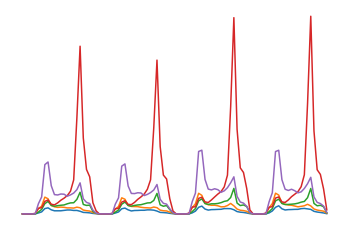

In [68]:
plt.axis('off')
plt.plot(sample_cols)
plt.show()

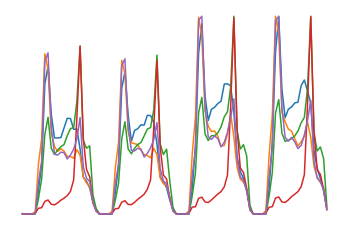

지하철역,4.19민주묘지,가능,가락시장,가산디지털단지,가양
202101_00시-01시 승차인원,0.000000,0.001801,0.000104,0.000162,0.000000
202101_01시-02시 승차인원,0.000000,0.000000,0.000000,0.000002,0.000000
202101_02시-03시 승차인원,0.000000,0.000000,0.000000,0.000000,0.000000
202101_03시-04시 승차인원,0.000000,0.000000,0.000000,0.000000,0.000000
202101_04시-05시 승차인원,0.000000,0.011404,0.000487,0.003064,0.000641
...,...,...,...,...,...
202104_19시-20시 승차인원,0.319974,0.239604,0.411514,0.420394,0.267657
202104_20시-21시 승차인원,0.231603,0.186401,0.318455,0.223536,0.181285
202104_21시-22시 승차인원,0.178055,0.158879,0.338364,0.199818,0.162419
202104_22시-23시 승차인원,0.117061,0.133671,0.281228,0.126226,0.123114


In [86]:
def norm_col(df, col):
    return col/df[col].max()

for col in sample_cols:
    norm_cols[col] = sample_cols[col] / sample_cols[col].max()

#norm_cols = sample_cols.apply(norm_col, axis = 1)
plt.clf()
plt.axis('off')
plt.plot(norm_cols)
plt.show()
norm_cols

### 2. Extract features using fourier transformation (or wavelet transfomr)

In [87]:
import pywt
w = pywt.families()
w = pywt.Wavelet('db4')
cA, cD = pywt.dwt(i['pm2.5'], wavelet = w)

In [117]:
w = pywt.Wavelet('db4')
wavelet_cols = pd.DataFrame()
for k, v in enumerate(norm_cols):
    cA, cD = pywt.dwt(norm_cols[v], wavelet = w)
    cA10 = sorted(cA, reverse = True)
    cD10 = sorted(cD, reverse = True)
    ext_cA = cA10[:10]
    ext_cD = cD10[:10]
    
    wavelet_cols[v] = [i for i in zip(ext_cA, ext_cD)]
wavelet_cols


,4.19민주묘지,가능,가락시장,가산디지털단지,가양
0,"(1.2192338627267798, 0.0671777158127938)","(1.3250793652367983, 0.07544359909505487)","(1.1555225435872076, 0.2855042779256265)","(1.032238717392142, 0.28775059654550816)","(1.339041884803789, 0.09777412023486395)"
1,"(1.1908499556229604, 0.04957716500887136)","(1.3155365074384295, 0.05807910944976685)","(1.143761181051704, 0.2838464301785546)","(1.0148372479640972, 0.2851790331104787)","(1.33867516518057, 0.09558308018590118)"
2,"(0.9328531948717605, 0.0392316336103226)","(1.0691883712767407, 0.04673051432999187)","(0.9843294947987206, 0.22803545171328418)","(0.8767553427195232, 0.2275946791929747)","(1.0751964330598802, 0.09441488547995323)"
3,"(0.9161685670812014, 0.03347963662021468)","(1.0255909928105693, 0.04236836542584117)","(0.9330820036153963, 0.22476847762322355)","(0.8043840484678104, 0.22017429152366097)","(1.0340074034951663, 0.08304635990852753)"
4,"(0.9150619596693264, 0.03075194018557728)","(0.8022153468678175, 0.022579203908977025)","(0.7259734328740843, 0.05257083843223512)","(0.6523173716538073, 0.04216202801213095)","(0.7977293255612292, 0.045130648149957826)"
5,"(0.9100796731169745, 0.029681368175837608)","(0.787672379999365, 0.021694079662966735)","(0.7176018769815236, 0.050150137138854994)","(0.6426985518386638, 0.03997611620597895)","(0.7936274370736014, 0.04245384850172716)"
6,"(0.9028864403548821, 0.02778412430652549)","(0.6695382903601825, 0.02096482506550616)","(0.6773834137617247, 0.03372134841380148)","(0.596885488600385, 0.009947805086818284)","(0.7774581012917815, 0.03583530904921499)"
7,"(0.9009274407912744, 0.021038402368540238)","(0.6342728443206116, 0.019928750334089224)","(0.6621833341836291, 0.02782259387479636)","(0.5277598967830673, 0.009123687348343396)","(0.760741595990673, 0.030278099444235068)"
8,"(0.8992881299525816, 0.02037787655403189)","(0.6286551144808785, 0.0180450673731637)","(0.6431743146010112, 0.02701789402993589)","(0.28461741551651254, 0.00846388562266222)","(0.6442545119435397, 0.023218804923232084)"
9,"(0.8596609387943172, 0.017592363941443055)","(0.623470774064197, 0.01443111619677607)","(0.599941117533634, 0.025103258738451775)","(0.27762160528057717, 0.005893802330996569)","(0.642003538590175, 0.017237974566196065)"


In [111]:
import seaborn as sns
sns.set(style = 'whitegrid')
np_cols = wavelet_cols.to_numpy()
m = np_cols.shape[0]
n = np_cols.shape[1]
print(np_cols)
plt.scatter(np_cols, c = 'black', label = '4.19민주묘지')
plt.show()

[[list([1.2192338627267798, 0.0671777158127938])]
 [list([1.1908499556229604, 0.04957716500887136])]
 [list([0.9328531948717605, 0.0392316336103226])]
 [list([0.9161685670812014, 0.03347963662021468])]
 [list([0.9150619596693264, 0.03075194018557728])]
 [list([0.9100796731169745, 0.029681368175837608])]
 [list([0.9028864403548821, 0.02778412430652549])]
 [list([0.9009274407912744, 0.021038402368540238])]
 [list([0.8992881299525816, 0.02037787655403189])]
 [list([0.8596609387943172, 0.017592363941443055])]]


TypeError: scatter() missing 1 required positional argument: 'y'

### 3.Cluster based on similarity

In [ ]:
co

In [ ]:
for k, i in enumerate(inputs):
    fig, ax = plt.subplots(figsize = (15, 5))
    ax.plot(i['pm2.5'].reset_index(drop = True), label ='Actual')
    cA, cD = pywt.dwt(i['pm2.5'], wavelet = w)
    cA4000 = sorted(cA, reverse = True)[4000]
    cD4000 = sorted(cD, reverse = True)[4000]
    ext_cA = [i if i >= cA4000 else 0 for i in cA]
    ext_cD = [i if i >= cD4000 else 0 for i in cD]
    recon = pywt.idwt(ext_cA, ext_cD, wavelet = w)
    ax.plot(recon, label = 'IDWT - Extract upper 4000 of cA & cD')
    plt.xticks(month_ticks[k], month_label)
    plt.title(label = 'PM in 201{} with IDWT'.format(str(k)))
    plt.legend()
    plt.show()
    fig.savefig('./Rawdata/P8_figure/PM in 201{} with IDWT.png'.format(str(k)))